In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from ipywidgets import interactive

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [2]:
# Functions
def eom_nonlinear( t, state, fr, κ0, κ1, λ, drive, ddrive ):
    ωr = 2 * np.pi * fr
    state_norm = state / np.sqrt(gain)
    drive_norm = drive(t) / np.sqrt(att)
    ddrive_norm = ddrive(t) / np.sqrt(att)
    return  np.sqrt(gain) * ( -1.0j*ωr*( state_norm-drive_norm ) - κ0*( state_norm-drive_norm ) - κ1*( state_norm-drive_norm )**3 + ddrive_norm + λ**2*drive_norm )


def eom_nonlinear_real( t, state_real, fr, κ0, κ1, λ, drive, ddrive ):
    state_complex = state_real[::2] + 1j*state_real[1::2]
    ret_complex = eom_nonlinear( t, state_complex, fr, κ0, κ1, λ, drive, ddrive )
    tmp = np.zeros( len(ret_complex)*2 )
    tmp[::2] = np.real( ret_complex )
    tmp[1::2] = np.imag( ret_complex )
    return tmp


def imp_drive( t, f1, f2, F0, phi1=0, phi2=0 ):
    ω1 = 2*π * f1
    ω2 = 2*π * f2
    return F0 * ( np.cos(ω1*t + phi1) + np.cos(ω2*t + phi2) )


def imp_drive_derivative( t, f1, f2, F0 ):
    ω1 = 2*π * f1
    ω2 = 2*π * f2
    return -F0 * ( ω1*np.sin(ω1*t) + ω2*np.sin(ω2*t) )


def nonlinear_simulation( f0, κ0, κ1, λ, f1, f2, F0 ):
        
    # Drive tones
    drive = partial( imp_drive, f1=f1, f2=f2, F0=F0 )
    ddrive = partial( imp_drive_derivative, f1=f1, f2=f2, F0=F0 )
    
    # Integrator
    o = ode( eom_nonlinear_real ).set_integrator( 'lsoda', atol=1e-12 , rtol=1e-12 )
    o.set_f_params( f0, κ0, κ1, λ, drive, ddrive )
    o.set_initial_value( y0, 0 )
    
    # Time-domain solution
    y_all = np.zeros(( len(t_all), len(y0) ))
    for i,t in enumerate( t_all ):
        o.integrate(t)
        y_all[i] = o.y
        
    
    # Merge the results onto the complex plane
    a_all = y_all[:,0] + 1.0j*y_all[:,1]
    
    # We save one oscillation once we reached the steady state
    a = a_all[-N-1:-1]
    t = t_all[-N-1:-1]
    
    # Fourier domain solution
    A = np.fft.fft( a ) / len(a)
    f = np.fft.fftfreq( len(t), d=dt )


    # Indices of the IMPs
    max_ind_pos = find_peaks( x = np.abs(A[:1000]),
                          height = 1e-9,
                          )
    max_ind_neg = find_peaks( x = np.abs(A[-1000:-900]),
                          height = 1e-8,
                          )
    
    max_ind = np.append( max_ind_pos[0], len(A)-1000+max_ind_neg[0] )
    print( 'Number of peaks: ', len(max_ind) )
        
    # Drive indices
    ind_drives = np.array([ 954, 956, 19044, 19046 ])
    
    # Generated drive array in the frequency and time domain
    Ain = np.zeros_like( A, dtype=complex )
    Ain[ind_drives] = 0.5
    ain = np.fft.ifft( Ain )
    ain *= len(ain)
    
    return A, Ain, a_all, a, ain, f, t_all, t, drive, max_ind


def recon_nonlinear( A, Ain, a, ain, f, max_ind ):
    
    # Angular frequency
    ω = 2*π * f
    
    # Create H-matrix
    col1 = (1.0j*ω*( A/np.sqrt(gain) - Ain/np.sqrt(att) ))[max_ind]
    col2 = 1.0j*( A/np.sqrt(gain) - Ain/np.sqrt(att) )[max_ind]
    col3 = ( A/np.sqrt(gain) - Ain/np.sqrt(att) )[max_ind]
    col4 = np.fft.fft( ( a/np.sqrt(gain) - ain/np.sqrt(att) )**3 )[max_ind] / len(a)
    
    # Merge all columns
    H = np.vstack(( col1, col2, col3, col4 ))
    
    # Making the matrix real instead of complex
    Hcos = np.real( H )
    Hsin = np.imag( H )
    H = np.hstack(( Hcos, Hsin ))
    
    # Normalize H for a more stable inversion
    Nm = np.diag( 1. / np.max(np.abs(H), axis=1) )
    H_norm = np.dot( Nm, H )  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real( Ain/np.sqrt(att) )[max_ind]
    Qsin = np.imag( Ain/np.sqrt(att) )[max_ind]
    Q = np.hstack(( Qcos, Qsin ))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv( H_norm )
    p_norm = np.dot( Q, H_norm_inv )
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot( Nm, p_norm )  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot( p, H )
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    λ_recon = 1 / param_recon[0]
    f0_recon = λ_recon * param_recon[1] / (2*π)
    κ0_recon = λ_recon * param_recon[2]
    κ1_recon = λ_recon * param_recon[3]
    
    return λ_recon, f0_recon, κ0_recon, κ1_recon, Q_fit, Q

In [3]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1 = 0.954
f2 = 0.956
df = 0.001
fs = 20
N = int(round(fs/df))

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
t_all = dt * (np.arange( (T+T_relax)/dt ) + 1) 

# Initial conditions
y0 = [0,0]

In [6]:
# System parameters
f0 = 0.955
κ0 = 0.025
κ1 = κ0/100
Q_factor = 1 / (2*κ0)

print( "NON-LINEAR DAMPING OSCILLATOR")
print( f'f0 = {f0:.5f} Hz' )
print( f'κ0 = {κ0:.5f}' )
print( f'κ1 = {κ1:.5f}' )
print( f'λ = {λ:.5f}' )
print( f'Q_factor = {Q_factor:.5f}' )


# Simulation
A, Ain, a_all, a, ain, f, t_all, t, drive, max_ind = nonlinear_simulation( f0, κ0, κ1, λ, f1, f2, F0 )

NON-LINEAR DAMPING OSCILLATOR
f0 = 0.95500 Hz
κ0 = 0.02500
κ1 = 0.00025
λ = 1.00000
Q_factor = 20.00000
Number of peaks:  20


f0_recon = 0.95500 Hz
κ0_recon = 0.02500
κ1_recon = 0.00025
λ_recon = 1.00000
Q_recon = 20.00000
----------------------------------


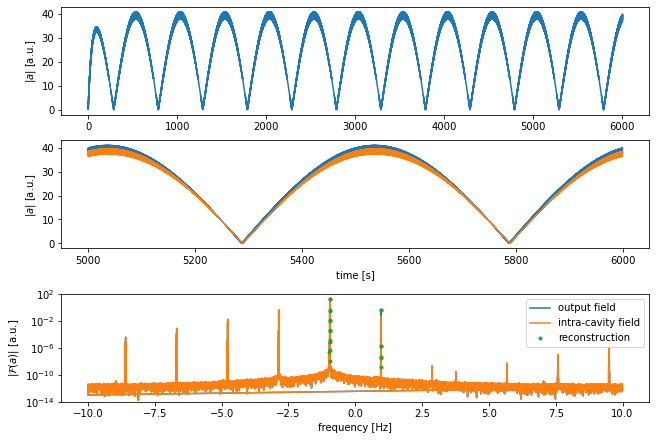

In [12]:
%matplotlib inline
verbose = False

# Check that the generated drive matches with the simulated drive
if verbose:
    # Drive array in time domain
    ain_all_simu = drive(t_all)
    ain_simu = ain_all_simu[-N-1:-1]
    Ain_simu = np.fft.fft(ain_simu) / len(ain_simu)
    
    # Drives in time and frequency domain
    fig, ax = plt.subplots( 3, 1, figsize=[9, 6] )
    ax[0].plot( t_all, np.abs(ain_all_simu) )
    ax[1].plot( t, np.abs(ain_simu), label='Simulated' )
    ax[1].plot( t, np.abs(ain), label='Generated' )
    ax[2].semilogy( f, np.abs(Ain_simu), label='Simulated' )
    ax[2].semilogy( f, np.abs(Ain), label='Generated' )
    ax[0].set_ylabel( '$|a_{in}|$ [a.u.]' )
    ax[1].set_xlabel( 'time [s]' )
    ax[1].set_ylabel( '$|a_{in}|$ [a.u.]' )
    ax[2].set_xlabel( 'frequency [Hz]' )
    ax[2].set_ylabel( '$|\mathcal{F}(a_{in})|$ [a.u.]' )
    ax[0].set_ylim( -0.1, 3 )
    ax[2].set_ylim( 1e-17, 100 )
    ax[2].legend()


# Intra-cavity field in time and frequency domain
fig, ax = plt.subplots( 3, 1, figsize=[9, 6] )
ax[0].plot( t_all, np.abs(a_all) )
ax[1].plot( t, np.abs(a), label='output field'  )
ax[1].plot( t, np.abs(a/np.sqrt(gain)-ain/np.sqrt(att)), label='intra-cavity field' )
ax[2].semilogy( f, np.abs(A), label='output field' )
ax[2].semilogy( f, np.abs(A/np.sqrt(gain)-Ain/np.sqrt(att)), label='intra-cavity field' )
ax[2].semilogy( f[max_ind], np.abs(A[max_ind]), '.', label='reconstruction' )
ax[0].set_ylabel( '$|a|$ [a.u.]' )
ax[1].set_xlabel( 'time [s]' )
ax[1].set_ylabel( '$|a|$ [a.u.]' )
ax[2].set_xlabel( 'frequency [Hz]' )
ax[2].set_ylabel( '$|\mathcal{F}(a)|$ [a.u.]' )
ax[2].set_ylim( 1e-14, 100 )
ax[2].legend()    


# Reconstruction section
λ_recon, f0_recon, κ0_recon, κ1_recon, Q_fit, Q = recon_nonlinear( A, Ain, a, ain, f, max_ind )
Q_recon = 1 / (2*κ0_recon)

print( f'f0_recon = {f0_recon:.5f} Hz' )
print( f'κ0_recon = {κ0_recon:.5f}' )
print( f'κ1_recon = {κ1_recon:.5f}' )
print( f'λ_recon = {λ_recon:.5f}' )
print( f'Q_recon = {Q_recon:.5f}' )
print( "----------------------------------")

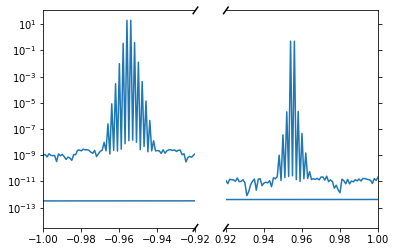

In [34]:
# Plot only the region of interest

# create two subplots
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=False)

# Plot same data on both axis
ax[0].semilogy( f, np.abs(A), label='output field' )
ax[1].semilogy( f, np.abs(A), label='output field' )

# limit each x axis to the chosen range
ax[0].set_xlim(-1, -0.92)
ax[1].set_xlim(0.92, 1)

# hide spines between both axes
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.tick_right()

d = .015 # how big to make the diagonal lines in axes coordinates

# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d,1+d), (-d,+d), **kwargs)
ax[0].plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d,+d), (1-d,1+d), **kwargs)
ax[1].plot((-d,+d), (-d,+d), **kwargs)

# vary the distance between plots 
fig.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
# Power Sweep

# System parameters
f0 = 0.955
κ0 = 0.025
κ1 = κ0/100
Q_factor = 1 / (2*κ0)

print( "NON-LINEAR DAMPING OSCILLATOR")
print( f'f0 = {f0:.5f} Hz' )
print( f'κ0 = {κ0:.5f}' )
print( f'κ1 = {κ1:.5f}' )
print( f'λ = {λ:.5f}' )
print( f'Q_factor = {Q_factor:.5f}' )

def F0_sweep( F0_val ):
    
    # Simulation section
    A, Ain, a_all, a, ain, f, t_all, t, drive, max_ind = nonlinear_simulation( f0, κ0, κ1, λ, f1, f2, F0_val )
    
    print( 'Number of peaks: ', len(max_ind) )
    
    # Reconstruction section
    λ_recon, f0_recon, κ0_recon, κ1_recon, Q_fit, Q = recon_nonlinear( A, Ain, a, ain, f, max_ind )


    # Output field as a function of F0
    # Plot same data on both axis
    ax[0].semilogy( f, np.abs(A), label='output field' )
    ax[1].semilogy( f, np.abs(A), label='output field' )

    # limit each x axis to the chosen range
    ax[0].set_xlim(-1, -0.92)
    ax[1].set_xlim(0.92, 1)

    # hide spines between both axes
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].yaxis.tick_right()

    d = .015 # how big to make the diagonal lines in axes coordinates

    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
    ax[0].plot((1-d,1+d), (-d,+d), **kwargs)
    ax[0].plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
    ax[1].plot((-d,+d), (1-d,1+d), **kwargs)
    ax[1].plot((-d,+d), (-d,+d), **kwargs)

    # vary the distance between plots 
    fig.subplots_adjust(wspace=0.2)
    plt.show()


widgets.interact( F0_sweep, 
                  F0_val=widgets.IntSlider(min=1, 
                                           max=4, 
                                           step=3,
                                           description='F0',
                                         )
                )